#  Unsupervised learning addition model

Author: S. Menary [sbmenary@gmail.com]

Date: 5/4/2023  (last update: 9/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $A \pm B$ for integers $A,B\in\mathbb{Z}\left([-N,~N]\right)$ for some maximum-amplitude $N$, and the output is a text representation of the answer. Since the output is a numerical value, the loss function is a sparse categorical entropy

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import configparser, datetime, json, logging, math, os, pickle, random, sys, time

##  Import entire pypi packages
import matplotlib as mpl
import numpy      as np
import tensorflow as tf

##  Import individual modules/objects from python stdlib packages
from pathlib import Path

##  Import individual modules/objects from pypi packages
from tensorflow.keras.callbacks  import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers     import Average, Concatenate, Dense, Embedding, Input, Layer, Masking
from tensorflow.keras.losses     import SparseCategoricalCrossentropy
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from matplotlib                  import pyplot as plt

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer.data       import train_val_test_split, TokenTransform
from mathsformer.tf_objects import (create_custom_objects_dict, get_nested_sublayers, masked_accuracy, 
                                    masked_sparse_categorical_crossentropy, AttentionBlock, DecoderBlock, 
                                    EncoderBlock, Enumerate, FeedForwardBlock, LayerActivationRecord, LayerWeightsRecord, 
                                    LoggerCallback, MetricRecord, PositionalEncoding, ReduceSequence, RightSlice)
from mathsformer.utils      import create_working_directory, fancy_message, initialise_program, log_versions, summarise_dict


### Configuation

Set global configuration variables

In [2]:
##===================##
##   Global config   ##
##===================##

##  Create dictionary of config values
##  -  config values to be set here and never changed!
##  -  use nested dictionary as a proxy for namespacing
##  -  e.g. can access data config value like config["data"]["label_prescale"]
global_config = {
    "base_seed"         : -1,
    "working_directory" : "unsupervised_learning_addition_model_[tag]_[date]_[time]",
    "tag"               : "baseline",
    "log_lvl_iostream"  : logging.INFO,
    "log_lvl_fstream"   : logging.DEBUG,
    "data" : {
        "max_int"        : 1499,
        "characters"     : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"      : 'M',
        "seq_start_char" : 'B',
        "seq_end_char"   : 'E',
        "negative_char"  : 'N',
        "test_split_idx" : 0.02,
        "val_split_idx"  : 0.04,
        "dtype"          : "int32",
    },
    "model" : {
        "load_pretrained_model" : "",
        "ndim_model"            : 32,
        "ndim_embedding"        : 32,
        "num_freqs"             : 16,
        "min_period"            : 4,
        "max_period"            : 250,
        "num_pre_layers_encoder": 2,
        "ndim_pre_layers"       : 128,
        "num_encoder_layers"    : 5,
        "num_heads"             : 8,
        "ndim_att_hidden"       : 32,
        "ndim_ff_hidden"        : 128,
        "num_pre_layers_decoder": 2,
        "num_decoder_layers"    : 5,
        "num_post_layers"       : 3,
        "ndim_post_layers"      : 256,
        "dropout"               : 0.1,
        "learning_rate"         : 1e-4,
        "dtype"                 : "float32"
    },
    "training" : {
        "train"                   : True,
        "max_epochs"              : 1000,
        "batch_size"              : 32,
        "early_stopping"          : True,
        "early_stopping_patience" : 2,
        "layer_activation_record_batch_frequency" : 250, 
        "layer_activation_record_max_datapoints"  : 32, 
        "layer_weights_record_batch_frequency" : 250, 
        "layer_weights_record_recursive"       : True, 
        "loss_record_batch_frequency" : 500, 
        "loss_record_max_datapoints"  : 512, 
        "loss_record_num_bootstrap"   : 20,
        "loss_record_plot_frequency"  : 10000, 
        "loss_record_plot_after_epoch": True, 
    },
    "evaluate" : {
        "num_bootstrap" : 100,
        "num_print"     : 40,
    },
}


##  Report success
print(fancy_message(f"Created global_config"))

===   Created global_config   ===


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [3]:
##===============================##
##   Global config - continued   ##
##===============================##

def validate_config(config) :
    """Raise exceptions in the case of program misconfigurations"""
    mask_char      = global_config["data"]["mask_char"]
    seq_start_char = global_config["data"]["seq_start_char"]
    seq_end_char   = global_config["data"]["seq_end_char"]
    negative_char  = global_config["data"]["negative_char"]
    char_tokens    = global_config["data"]["characters"]
    
    ##  Check that only single character tokens are provided
    for char_token in char_tokens :
        if len(char_token) == 1 : continue
        raise ValueError(f"All character tokens must be single characters but '{char_tokens}' found")
        
    ##  Check mask character is provided
    if len(mask_char) != 1 :
        raise ValueError(f"Mask character must be a single character but '{mask_char}' provided")
        
    ##  Check mask character in character list
    if mask_char not in char_tokens :
        raise ValueError(f"Mask character '{mask_char}' not found in character list: {char_tokens}")
    
    ##  Check that mask character is first in char_tokens list (ensures it's assigned a token of 0)
    if char_tokens[0] != mask_char :
        raise ValueError(f"Mask character '{mask_char}' must be the first in the char_tokens list provided, "
                        +f"instead found list: {char_tokens}")
        
    ##  Check seq_start_char character is provided
    if len(seq_start_char) != 1 :
        raise ValueError(f"Sequence start character must be a single character but '{seq_start_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_start_char not in char_tokens :
        raise ValueError(f"Sequence start character '{seq_start_char}' not found in character list: {char_tokens}")
        
    ##  Check seq_end_char character is provided
    if len(seq_end_char) != 1 :
        raise ValueError(f"Sequence end character must be a single character but '{seq_end_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_end_char not in char_tokens :
        raise ValueError(f"Sequence end character '{seq_end_char}' not found in character list: {char_tokens}")
        
    ##  Check negative_char character is provided
    if len(negative_char) != 1 :
        raise ValueError(f"Negative symbol character must be a single character but '{negative_char}' provided")
        
    ##  Check negative_char character in character list
    if negative_char not in char_tokens :
        raise ValueError(f"Negative symbol character '{negative_char}' not found in character list: {char_tokens}")
        
    ##  If here then config validated correctly
    print(fancy_message("Config successfully validated"))
    
validate_config(global_config)

===   Config successfully validated   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = initialise_program(
    "unsupervised_learning_model notebook", 
    working_dir       = global_config["working_directory"], 
    global_config     = global_config,
    log_lvl_iostream  = global_config["log_lvl_iostream"],
    log_lvl_fstream   = global_config["log_lvl_fstream" ],
)


===   Working directory created at unsupervised_learning_addition_model_baseline_2023_04_11_202120   ===
   INFO initialise_logging: Begin logging on 2023-04-11 at 20:21:20
   INFO initialise_program: Program description: unsupervised_learning_model notebook
   INFO initialise_program: Working directory: unsupervised_learning_addition_model_baseline_2023_04_11_202120
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                               Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO log_versions:                                          

   INFO log_versions:                                 platformdirs.version  |  2.6.0
   INFO log_versions:                                       prompt_toolkit  |  3.0.36
   INFO log_versions:                                               psutil  |  5.9.4
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.1
   INFO log_versions:                                             pygments  |  2.13.0
   INFO log_versions:                                            pyparsing  |  3.0.9
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.28.1
   INFO log_versions:                                 requests

   INFO initialise_program: Registered global config value model > num_encoder_layers: 5
   INFO initialise_program: Registered global config value model > num_heads: 8
   INFO initialise_program: Registered global config value model > ndim_att_hidden: 32
   INFO initialise_program: Registered global config value model > ndim_ff_hidden: 128
   INFO initialise_program: Registered global config value model > num_pre_layers_decoder: 2
   INFO initialise_program: Registered global config value model > num_decoder_layers: 5
   INFO initialise_program: Registered global config value model > num_post_layers: 3
   INFO initialise_program: Registered global config value model > ndim_post_layers: 256
   INFO initialise_program: Registered global config value model > dropout: 0.1
   INFO initialise_program: Registered global config value model > learning_rate: 0.0001
   INFO initialise_program: Registered global config value model > dtype: float32
   INFO initialise_program: Registered global con

##  3. Create training data

###  Generate string-string pairs

In [5]:
##===================================##
##   Define data wrangling methods   ##
##===================================##

def generate_raw_dataset(max_int:int=999, include_neg:bool=True, shuffle:bool=True, negative_char:str='N') :
    '''
    Create dataset where input is str of "A+B" or "A-B", and output is str containing the answer
    A and B are positive or negative integers with maximum amplitude given
    '''
    logger.info(f"generate_raw_dataset(): called with max_int={max_int:,}, include_neg={include_neg}, shuffle={shuffle}")
    start_time = time.time()
    if include_neg : singles = np.arange(-max_int, max_int+1, dtype=np.int32) 
    else           : singles = np.arange(0       , max_int+1, dtype=np.int32)
    pairs   = np.array([[(x,y) for x in singles] for y in singles])
    pairs   = np.concatenate(pairs)
    summed  = pairs[:,0] + pairs[:,1]
    minus   = pairs[:,0] - pairs[:,1]
    dataset = []
    for (i1, i2), s, m in zip(pairs, summed, minus) :
        i1, i2 = f"{i1}".replace("-",negative_char), f"{i2}".replace("-",negative_char)
        s , m  = f"{s }".replace("-",negative_char), f"{m }".replace("-",negative_char)
        dataset.append((f"{i1}+{i2}", f"{s}"))
        dataset.append((f"{i1}-{i2}", f"{m}"))
    np.random.shuffle(dataset)
    logger.info(f"generate_raw_dataset(): created dataset with length {len(dataset):,} in {time.time()-start_time:.1f}s")
    return dataset


###   Process strings into fixed-length tokenised dataset with position indices

In [6]:
##===================================##
##   Create dataset of raw strings   ##
##===================================##

raw_dataset = generate_raw_dataset(global_config["data"]["max_int"], 
                                   negative_char=global_config["data"]["negative_char"])


   INFO generate_raw_dataset: generate_raw_dataset(): called with max_int=1,499, include_neg=True, shuffle=True
   INFO generate_raw_dataset: generate_raw_dataset(): created dataset with length 17,988,002 in 14.0s


In [7]:
##======================================================##
##   Create TokenTransform object using config values   ##
##======================================================##

token_transform = TokenTransform.from_dictionary(global_config["data"])
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


In [8]:
##=============================================##
##   Convert raw data to tokenised sequences   ##
##=============================================##

start_time = time.time()
data_X     = token_transform.strings_to_tensor([x[0] for x in raw_dataset])
data_Y     = token_transform.strings_to_tensor([x[1] for x in raw_dataset])

logger.info(f"Strings converted to tensors with shape {data_X.shape}, {data_Y.shape} in {time.time()-start_time:.1f}s")

del raw_dataset


   INFO <module>: Strings converted to tensors with shape (17988002, 13), (17988002, 7) in 92.2s


In [9]:
##============================================##
##   Slice Y into input and output sequences  ##
##============================================##

data_Y_in, data_Y_out = data_Y[:,:-1], data_Y[:,1:]

del data_Y


In [10]:
##==================================##
##   Perform train/val/test split   ##
##==================================##

split_idx1 = global_config.get("data", {}).get("test_split_idx", 0.1)
split_idx2 = global_config.get("data", {}).get("val_split_idx" , 0.3)

test_X    , val_X    , train_X     = train_val_test_split(data_X    , split_idx1, split_idx2)
test_Y_in , val_Y_in , train_Y_in  = train_val_test_split(data_Y_in , split_idx1, split_idx2)
test_Y_out, val_Y_out, train_Y_out = train_val_test_split(data_Y_out, split_idx1, split_idx2)

logger.info(f"  Training data with shape {train_X.shape}, {train_Y_in.shape} and labels {train_Y_out.shape}")
logger.info(f"Validation data with shape {  val_X.shape}, {  val_Y_in.shape} and labels {  val_Y_out.shape}")
logger.info(f"      Test data with shape { test_X.shape}, { test_Y_in.shape} and labels { test_Y_out.shape}")

del data_X, data_Y_in, data_Y_out


   INFO <module>:   Training data with shape (17268482, 13), (17268482, 6) and labels (17268482, 6)
   INFO <module>: Validation data with shape (359760, 13), (359760, 6) and labels (359760, 6)
   INFO <module>:       Test data with shape (359760, 13), (359760, 6) and labels (359760, 6)


##  4.  Create model

In [11]:
##======================================##
##   Create supervised learning model   ##
##======================================##

def create_model(vocab_length:int, 
                 name=None, dtype=tf.float32, 
                 pos_enc_slice_index:int=None,
                 ndim_model:int=32, ndim_embedding:int=16, num_freqs:int=8, comb_type:str="average",
                 min_period:float=5, max_period:float=200, num_pre_layers_encoder:int=1, ndim_pre_layers:int=64, 
                 num_encoder_layers:int=3, num_heads:int=6, ndim_att_hidden:int=32, ndim_ff_hidden:int=64, 
                 num_pre_layers_decoder:int=1, num_decoder_layers:int=3, num_post_layers:int=1, 
                 ndim_post_layers:int=64, dropout=0.1, learning_rate:float=0.001, dtype_in=tf.int32, 
                 dtype_pos=tf.int32) :
    
    ##  Input layer - Shape [B, S, 2]
    x_in_enc = Input((None,), dtype=dtype_in, name=f"{name}_encoder_input_layer")
    x_in_dec = Input((None,), dtype=dtype_in, name=f"{name}_decoder_input_layer")
            
    ##  Token embedding - assuming input feature 0 is the token ID
    ##  Output shape [B, S, ndim_embedding]
    x_embed_enc = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_encoder_embedding")(x_in_enc)
    x_embed_dec = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_decoder_embedding")(x_in_dec)
    
    ##  Enumerate indices for positional encoding
    x_pos_enc = Enumerate(name=f"{name}_encoder_enumerate", dtype=dtype_pos)(x_in_enc, minimal_dims=True)
    x_pos_dec = Enumerate(name=f"{name}_decoder_enumerate", dtype=dtype_pos)(x_in_dec, minimal_dims=True)
    
    ##  Position encoding - assuming feature index pos_enc_slice_axis is the token index
    ##  -  Output shape [B, S, 2*num_freqs]
    x_pos_enc = PositionalEncoding(slice_index=pos_enc_slice_index,
                                   num_freqs=num_freqs, 
                                   min_period=min_period, 
                                   max_period=max_period, 
                                   dtype=dtype, 
                                   name=f"{name}_encoder_position_encoding")(x_in_enc)
    x_pos_dec = PositionalEncoding(slice_index=pos_enc_slice_index,
                                   num_freqs=num_freqs, 
                                   min_period=min_period, 
                                   max_period=max_period, 
                                   dtype=dtype, 
                                   name=f"{name}_decoder_position_encoding")(x_in_dec)
    
    ##  Combine embedding and position encoding according to the scheme provided
    ##  - Output shape [B, S, ndim_embedding + 2*num_freqs]
    allowed_comb_types = ["add", "sum", "average", "mean", "concat", "concatenate"]
    match comb_type.lower() :
        case "add" | "sum" :
            x_enc = Add(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Add(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "average" | "mean" :
            x_enc = Average(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Average(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "concat" | "concatenate" :
            x_enc = Concatenate(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Concatenate(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case _ :
            raise RuntimeError(f"comb_type '{comb_type}' not recognised, recognised keywords are {allowed_comb_types}")
    
    ##  If input to feed forward block is the same size as ndim_model then turn on skip_connect
    skip_connect_enc = (ndim_model==x_enc.shape[-1])
    skip_connect_dec = (ndim_model==x_dec.shape[-1])
    logger.info(f"Pre-attention skip connection set to encoder={skip_connect_enc}, decoder={skip_connect_dec}")
    
    ##  Do initial pre-processing and collapse to model size
    ##  - use layer_norm instead of batch_norm because tokens in sequence are not independent
    x_enc = FeedForwardBlock(ndim_model, 
                             ndim_hidden=ndim_pre_layers, 
                             num_hidden_layers=num_pre_layers_encoder, 
                             dropout=dropout, 
                             layer_norm=True, 
                             batch_norm=False,  
                             skip_connect=skip_connect_enc, 
                             dtype=dtype, 
                             name =f"{name}_encoder_feedfwd_block_pre_attention")(x_enc)
    x_dec = FeedForwardBlock(ndim_model, 
                             ndim_hidden=ndim_pre_layers, 
                             num_hidden_layers=num_pre_layers_decoder, 
                             dropout=dropout, 
                             layer_norm=True, 
                             batch_norm=False,  
                             skip_connect=skip_connect_dec, 
                             dtype=dtype, 
                             name =f"{name}_decoder_feedfwd_block_pre_attention")(x_dec)
    
    ##  Run encoder blocks
    for layer_idx in range(num_encoder_layers) :
        x_enc = EncoderBlock(ndim_model, 
                             num_heads, 
                             ndim_att_hidden, 
                             ndim_ff_hidden, 
                             dropout_mha=dropout, 
                             dtype=dtype, 
                             layer_norm=True, 
                             skip_connect=True, 
                             name=f"{name}_encoder_block_{layer_idx+1}")(x_enc)
    
    ##  Run decoder blocks
    for layer_idx in range(num_decoder_layers) :
        x_dec = DecoderBlock(ndim_model, 
                             num_heads, 
                             ndim_att_hidden, 
                             ndim_ff_hidden, 
                             dropout_mha=dropout, 
                             dtype=dtype, 
                             layer_norm=True, 
                             skip_connect=True, 
                             name=f"{name}_decoder_block_{layer_idx+1}")([x_dec, x_enc])
        
    ##  Collapse to model size
    x = FeedForwardBlock(vocab_length, 
                         ndim_hidden=ndim_post_layers, 
                         num_hidden_layers=num_post_layers, 
                         skip_connect=False, 
                         layer_norm=True, 
                         batch_norm=False, 
                         dtype=dtype, 
                         name=f"{name}_feedfwd_block_post_attention")(x_dec)
    
    ##  Create model
    model = Model([x_in_enc, x_in_dec], x, name=name)
    
    ##  Compile model with MSE loss for supervised learning to numerical output
    model.compile(loss      = masked_sparse_categorical_crossentropy, 
                  optimizer = Adam(learning_rate=learning_rate), 
                  metrics   = [masked_accuracy])
    
    ##  Return model
    return model
    

In [12]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_model(vocab_length           = token_transform.vocab_length, 
                     name                   = "mathsformer_LLM",
                     ndim_model             = global_config["model"]["ndim_model"],
                     ndim_embedding         = global_config["model"]["ndim_embedding"],
                     num_freqs              = global_config["model"]["num_freqs"],
                     min_period             = global_config["model"]["min_period"],
                     max_period             = global_config["model"]["max_period"],
                     num_pre_layers_encoder = global_config["model"]["num_pre_layers_encoder"],
                     ndim_pre_layers        = global_config["model"]["ndim_pre_layers"],
                     num_encoder_layers     = global_config["model"]["num_encoder_layers"],
                     num_heads              = global_config["model"]["num_heads"],
                     ndim_att_hidden        = global_config["model"]["ndim_att_hidden"],
                     ndim_ff_hidden         = global_config["model"]["ndim_ff_hidden"],
                     num_pre_layers_decoder = global_config["model"]["num_pre_layers_decoder"],
                     num_decoder_layers     = global_config["model"]["num_decoder_layers"],
                     num_post_layers        = global_config["model"]["num_post_layers"],
                     ndim_post_layers       = global_config["model"]["ndim_post_layers"],
                     dropout                = global_config["model"]["dropout"],
                     learning_rate          = global_config["model"]["learning_rate"],
                     dtype_in               = token_transform.dtype,
                     dtype                  = global_config["model"]["dtype"],)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

logger.info("Model created with summary:")
for s in model_summary : logger.info(s)


   INFO create_model: Pre-attention skip connection set to encoder=True, decoder=True
   INFO <module>: Model created with summary:
   INFO <module>: Model: "mathsformer_LLM"
   INFO <module>: __________________________________________________________________________________________________
   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     
   INFO <module>: ==================================================================================================
   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               
   INFO <module>:  layer (InputLayer)                                                                               
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_encoder_embedd  (None, None, 32)    512         ['mathsformer_LLM_encoder_input_l
   INF

   INFO <module>:                                                                  [0][0]']                         
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 32)    84480       ['mathsformer_LLM_decoder_block_3
   INFO <module>:  4 (DecoderBlock)                                                [0][0]',                         
   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_5
   INFO <module>:                                                                  [0][0]']                         
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 32)    84480       ['mathsformer_LLM_decoder_block_4
   INFO <module>:  5 (DecoderBlock)                             

##  5.  Train model

In [13]:
##===================================##
##   Create callbacks for training   ##
##===================================##


##  Create list of training callbacks
callbacks = []


##  Add logger callback
logger.info("Registering training callback: LoggerCallback with DEBUG log-level")
callbacks.append(LoggerCallback(logger, loglvl=logging.DEBUG))


##  Add callback for early stopping
if global_config["training"].get("early_stopping", True) :
    monitor, restore_best_weights = "val_loss", True
    patience = global_config["training"].get("early_stopping_patience", 1)
    logger.info(f"Registering training callback: EarlyStopping with monitor={monitor}, patience={patience}, restore_best_weights={restore_best_weights}")
    callbacks.append(EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights))
    
    
## Add callback for model checkpointing
if global_config["training"].get("model_checkpoint", True) :
    filepath = working_dir+"/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5"
    logger.info(f"Registering training callback: ModelCheckpoint with filepath={filepath}")
    callbacks.append(ModelCheckpoint(filepath=filepath))

    
##  Add callback to intermittently record loss over small subset of validation data
batch_frequency  = global_config.get("training").get("loss_record_batch_frequency", 1000)
max_datapoints   = global_config.get("training").get("loss_record_max_datapoints" , 2048)
num_bootstrap    = global_config.get("training").get("loss_record_num_bootstrap"  , 10)
plot_frequency   = global_config.get("training").get("loss_record_plot_frequency" , -1)
plot_after_epoch = global_config.get("training").get("loss_record_plot_after_epoch", False)
loss_record = MetricRecord(
    batch_frequency   = batch_frequency, 
    val_input         = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output        = val_Y_out[:max_datapoints],
    label             = "Partial\nval. loss.",
    yscale            = "log",
    num_bootstrap     = num_bootstrap,
    plot_on_train_end = True,
    plot_on_epoch_end = plot_after_epoch,
    plot_frequency    = plot_frequency,
    logger            = logger,
    log_lvl           = logging.DEBUG + 5,
)
logger.info(f"Registering training callback: MetricRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(loss_record)

    
##  Add callback to intermittently record loss over small subset of validation data
acc_record = MetricRecord(
    batch_frequency   = batch_frequency, 
    val_input         = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output        = val_Y_out[:max_datapoints],
    func              = masked_accuracy,
    label             = "Partial\nval. acc.",
    yscale            = "linear",
    num_bootstrap     = num_bootstrap,
    plot_on_train_end = True,
    plot_on_epoch_end = plot_after_epoch,
    plot_frequency    = plot_frequency,
    logger            = logger,
    log_lvl           = logging.DEBUG + 5,
)
logger.info(f"Registering training callback: MetricRecord (masked_accuracy) with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(acc_record)

    
##  Add callback to intermittently record layer activations
##  -  Since sublayers are not tracked by the computational graph, we cannot access sublayer.output within 
##     a keras function, and therefore we cannot track the activations of sublayers as we may wish
batch_frequency = global_config.get("training").get("layer_activation_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("layer_activation_record_max_datapoints" , 128)
layer_activation_record = LayerActivationRecord(
    batch_frequency = batch_frequency, 
    val_input       = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
)
logger.info(f"Registering training callback: LayerActivationRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}")
callbacks.append(layer_activation_record)


##  Add callback to intermittently record layer weights - use recursive=True to monitor all sublayers
batch_frequency = global_config.get("training").get("layer_weights_record_batch_frequency", 1000)
recursive       = global_config.get("training").get("layer_weights_record_recursive"      , True)
layer_weights_record = LayerWeightsRecord(
    batch_frequency = batch_frequency, 
    recursive       = recursive
)
logger.info(f"Registering training callback: LayerWeightsRecord with batch_frequency={batch_frequency}, recursive={recursive}")
callbacks.append(layer_weights_record)


   INFO <module>: Registering training callback: LoggerCallback with DEBUG log-level
   INFO <module>: Registering training callback: EarlyStopping with monitor=val_loss, patience=2, restore_best_weights=True
   INFO <module>: Registering training callback: ModelCheckpoint with filepath=unsupervised_learning_addition_model_baseline_2023_04_11_202120/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO <module>: Registering training callback: MetricRecord with batch_frequency=500, max_datapoints=512, num_bootstrap=20
   INFO <module>: Registering training callback: MetricRecord (masked_accuracy) with batch_frequency=500, max_datapoints=512, num_bootstrap=20
   INFO <module>: Registering training callback: LayerActivationRecord with batch_frequency=250, max_datapoints=32
   INFO <module>: Registering training callback: LayerWeightsRecord with batch_frequency=250, recursive=True


   INFO <module>: Begin model training with max_epochs=1000, batch_size=32
Epoch 1/1000


2023-04-11 20:23:11.047325: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  9999/539641 [..............................] - ETA: 22:22:59 - loss: 1.6292 - masked_accuracy: 0.4114

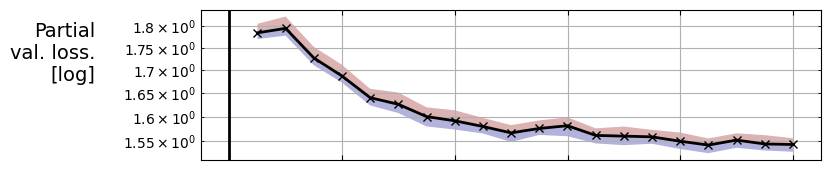

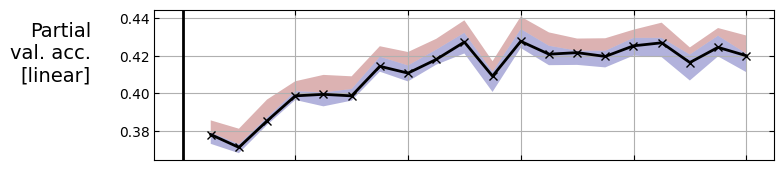

 19999/539641 [>.............................] - ETA: 21:41:51 - loss: 1.5751 - masked_accuracy: 0.4234

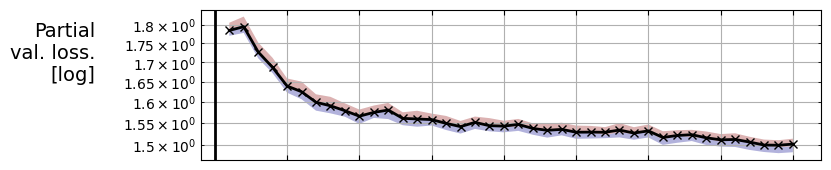

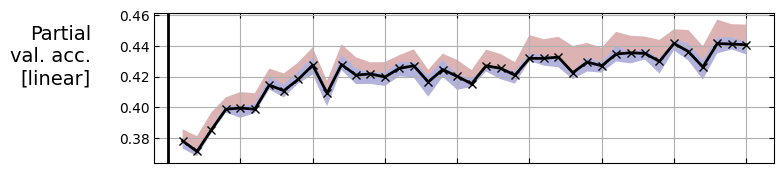

 29999/539641 [>.............................] - ETA: 21:25:50 - loss: 1.5411 - masked_accuracy: 0.4319

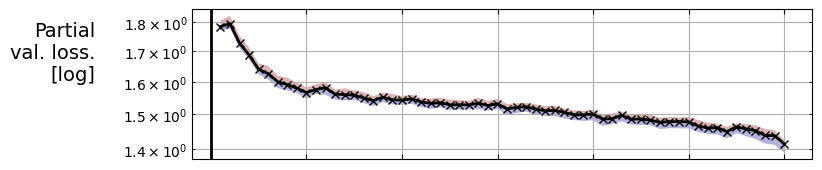

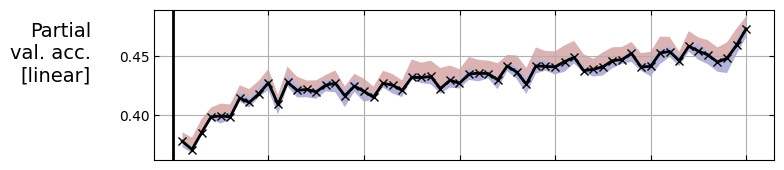

 39999/539641 [=>............................] - ETA: 20:59:58 - loss: 1.5034 - masked_accuracy: 0.4430

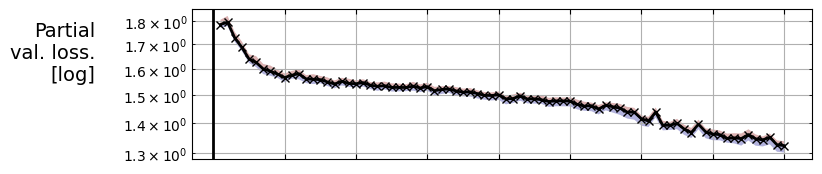

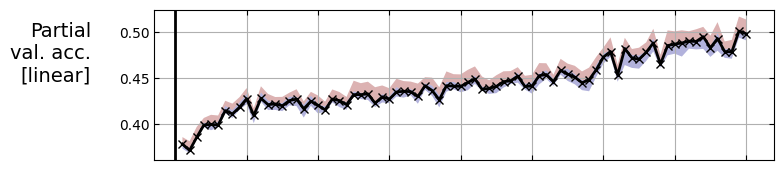

 49999/539641 [=>............................] - ETA: 20:20:59 - loss: 1.4691 - masked_accuracy: 0.4536

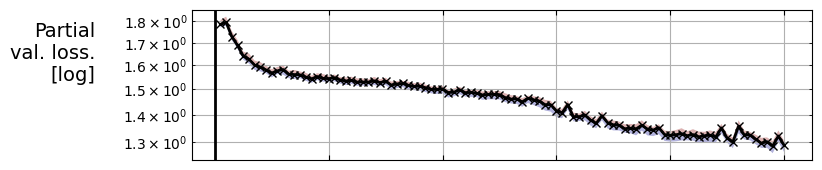

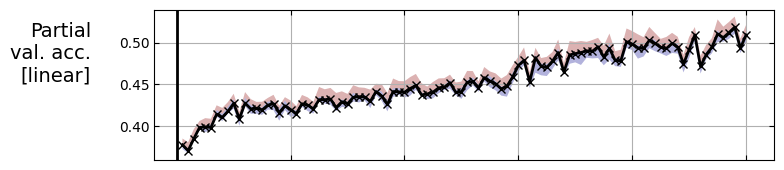

 59999/539641 [==>...........................] - ETA: 19:44:26 - loss: 1.4411 - masked_accuracy: 0.4627

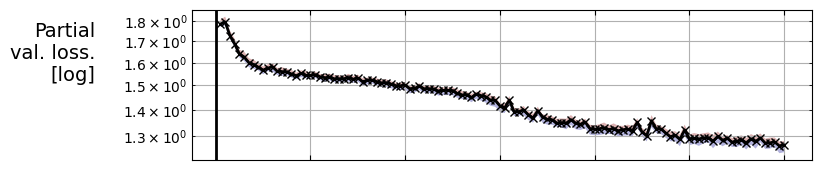

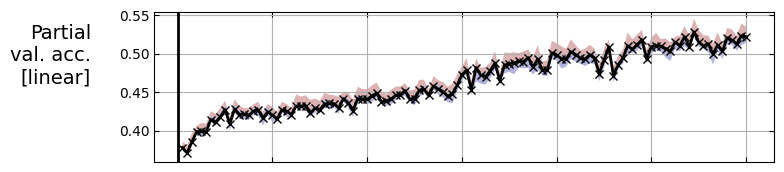

 69999/539641 [==>...........................] - ETA: 19:13:04 - loss: 1.4180 - masked_accuracy: 0.4702

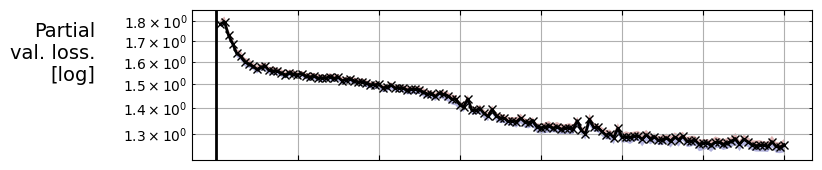

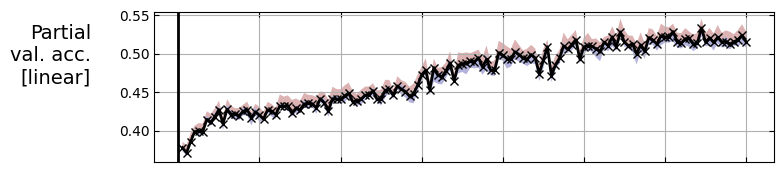

 79999/539641 [===>..........................] - ETA: 18:43:25 - loss: 1.3991 - masked_accuracy: 0.4765

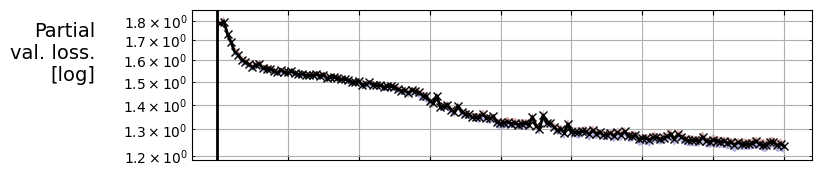

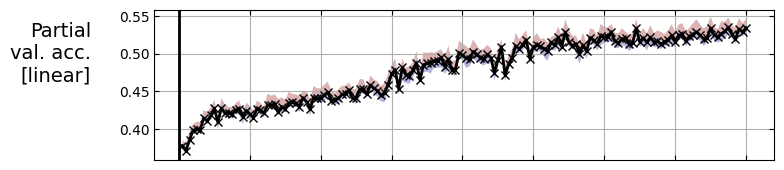

 89999/539641 [====>.........................] - ETA: 18:11:13 - loss: 1.3831 - masked_accuracy: 0.4818

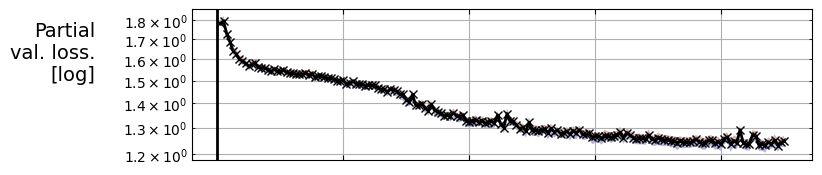

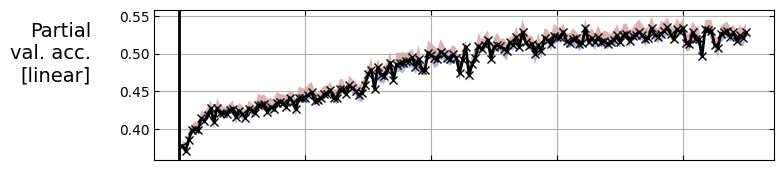

 99999/539641 [====>.........................] - ETA: 17:39:53 - loss: 1.3692 - masked_accuracy: 0.4864

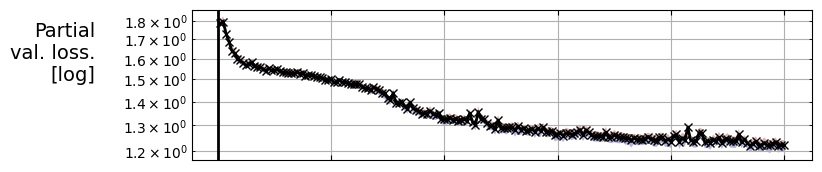

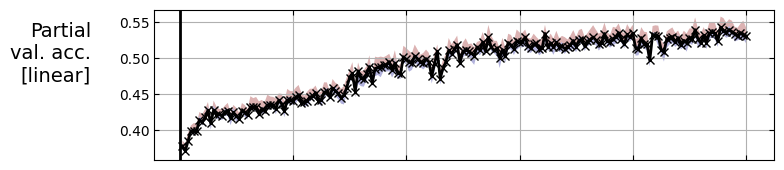

109999/539641 [=====>........................] - ETA: 17:08:18 - loss: 1.3571 - masked_accuracy: 0.4905

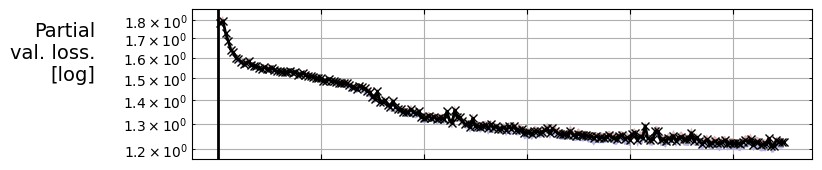

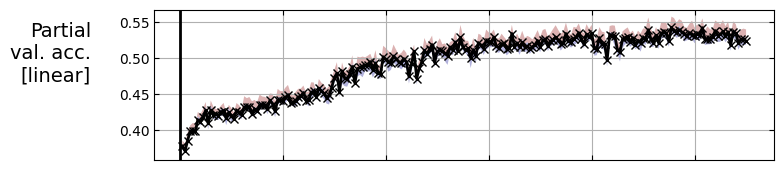

119999/539641 [=====>........................] - ETA: 16:39:26 - loss: 1.3466 - masked_accuracy: 0.4941

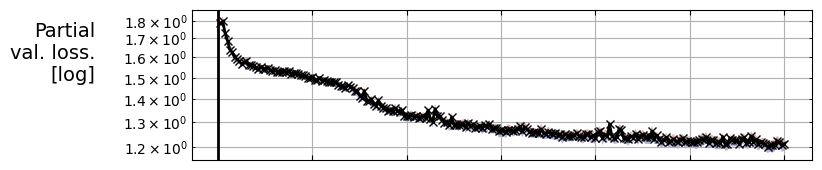

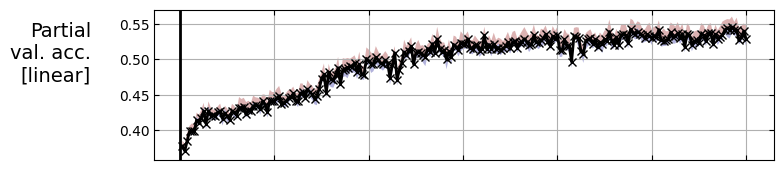

129999/539641 [======>.......................] - ETA: 16:12:45 - loss: 1.3369 - masked_accuracy: 0.4973

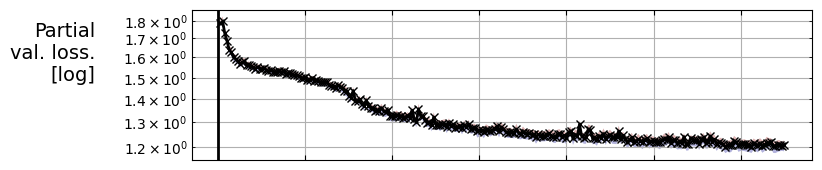

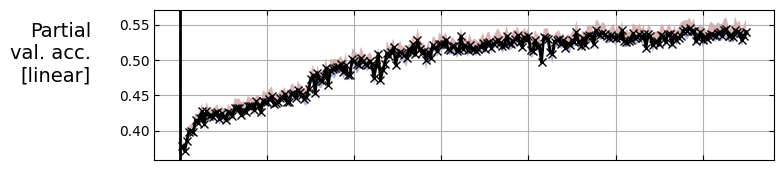

139999/539641 [======>.......................] - ETA: 15:48:02 - loss: 1.3283 - masked_accuracy: 0.5002

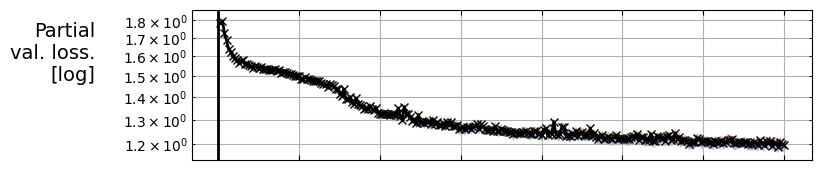

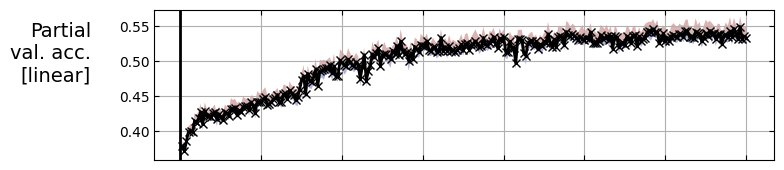

149999/539641 [=======>......................] - ETA: 15:22:44 - loss: 1.3207 - masked_accuracy: 0.5027

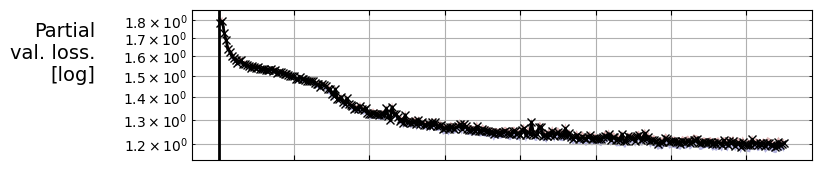

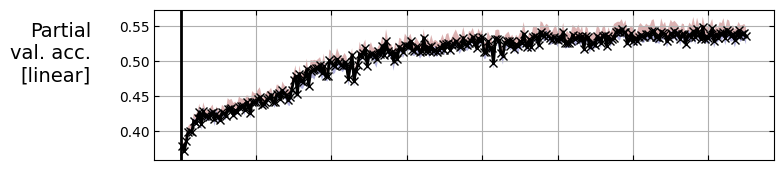

159999/539641 [=======>......................] - ETA: 14:56:15 - loss: 1.3137 - masked_accuracy: 0.5051

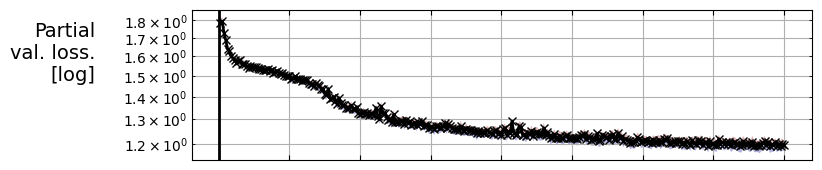

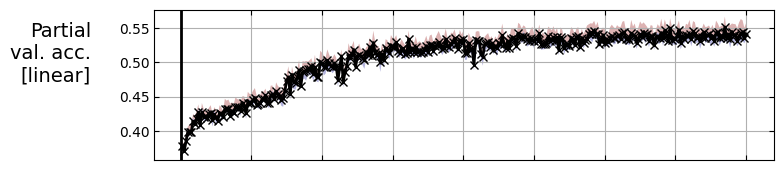

169999/539641 [========>.....................] - ETA: 14:31:52 - loss: 1.3072 - masked_accuracy: 0.5072

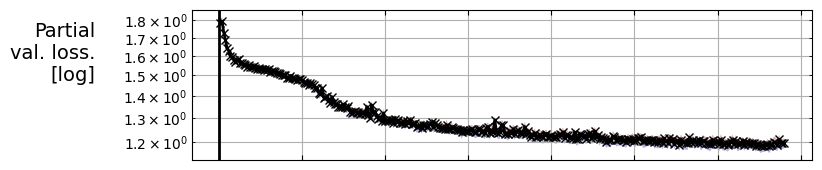

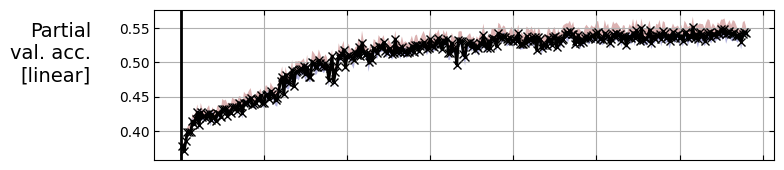

179999/539641 [=========>....................] - ETA: 14:08:40 - loss: 1.3012 - masked_accuracy: 0.5092

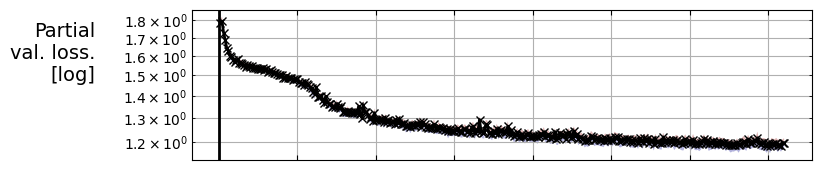

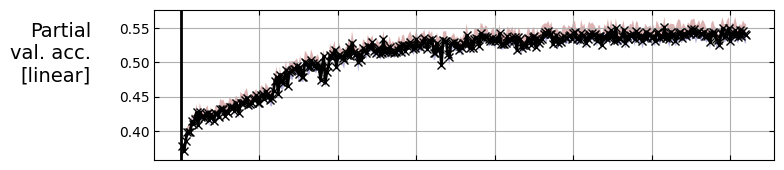

189999/539641 [=========>....................] - ETA: 13:44:26 - loss: 1.2958 - masked_accuracy: 0.5110

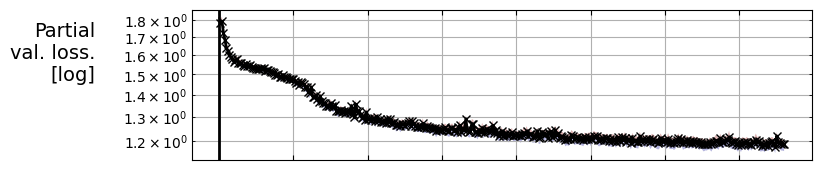

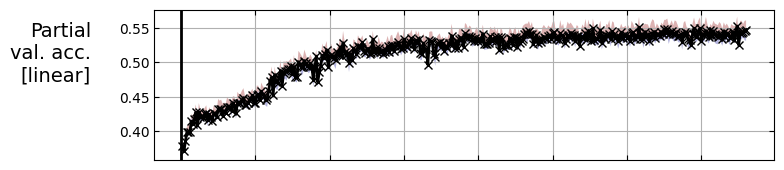

199999/539641 [==========>...................] - ETA: 13:19:45 - loss: 1.2907 - masked_accuracy: 0.5127

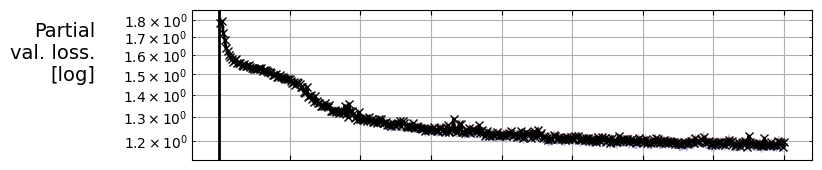

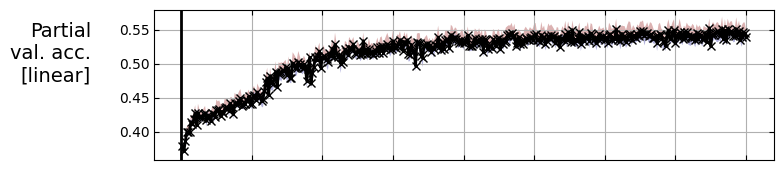

209999/539641 [==========>...................] - ETA: 12:55:54 - loss: 1.2858 - masked_accuracy: 0.5143

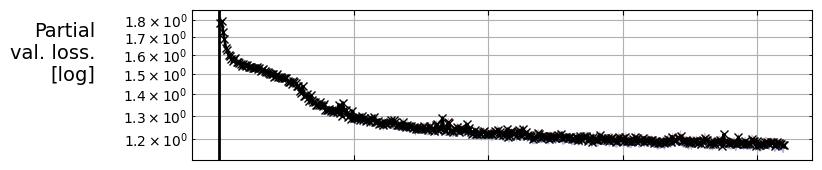

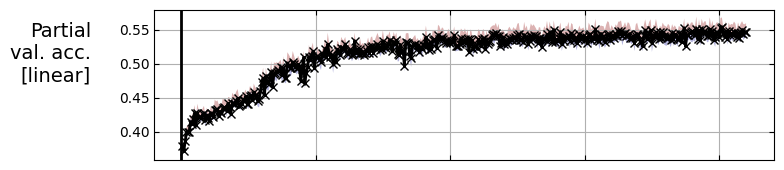

219999/539641 [===========>..................] - ETA: 12:32:37 - loss: 1.2813 - masked_accuracy: 0.5158

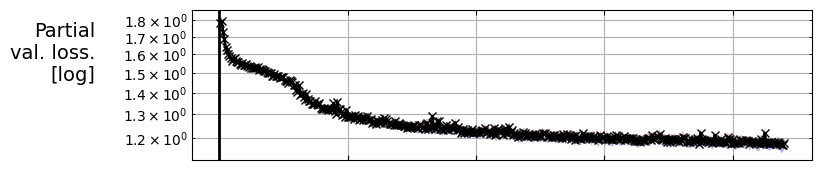

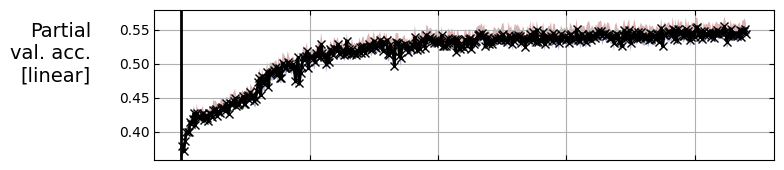

229999/539641 [===========>..................] - ETA: 12:11:16 - loss: 1.2770 - masked_accuracy: 0.5173

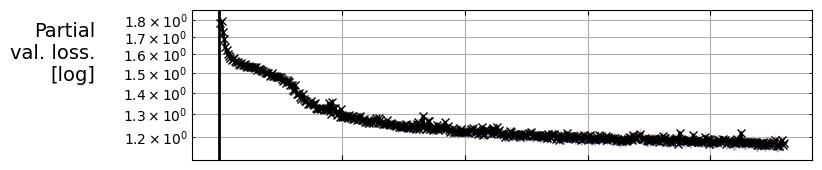

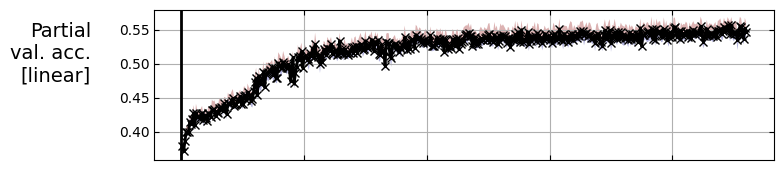

239999/539641 [============>.................] - ETA: 11:49:36 - loss: 1.2731 - masked_accuracy: 0.5186

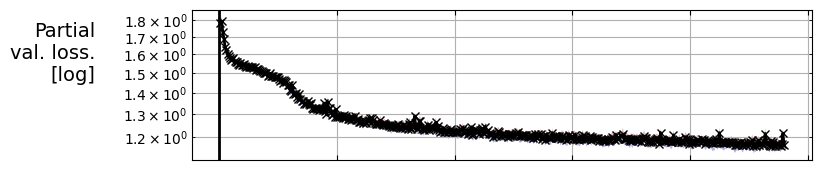

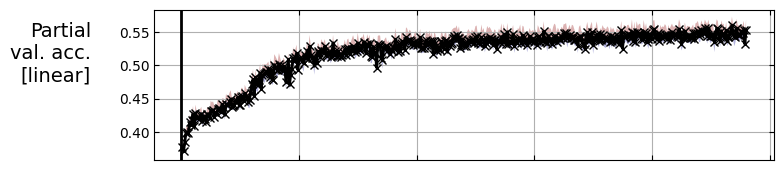

249999/539641 [============>.................] - ETA: 11:26:59 - loss: 1.2692 - masked_accuracy: 0.5199

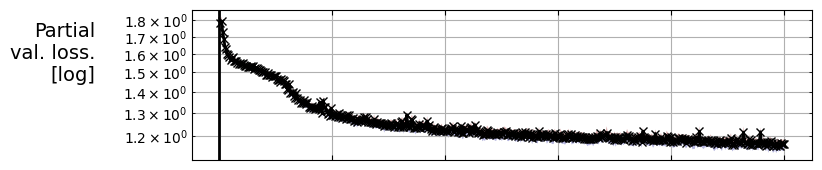

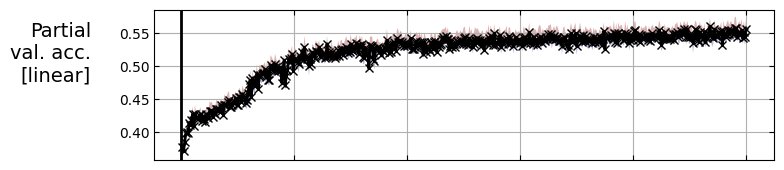

259999/539641 [=============>................] - ETA: 11:04:13 - loss: 1.2655 - masked_accuracy: 0.5212

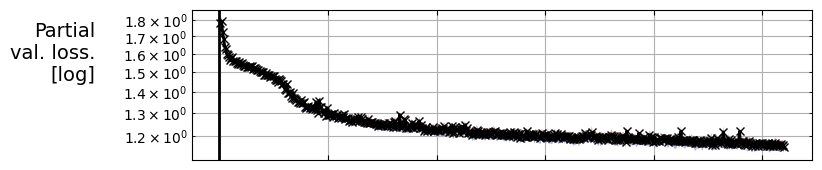

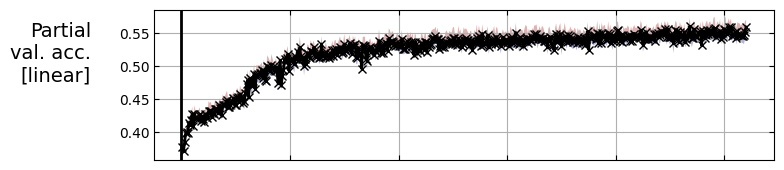

269999/539641 [==============>...............] - ETA: 10:42:41 - loss: 1.2620 - masked_accuracy: 0.5223

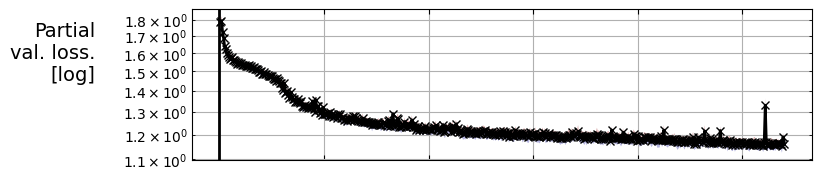

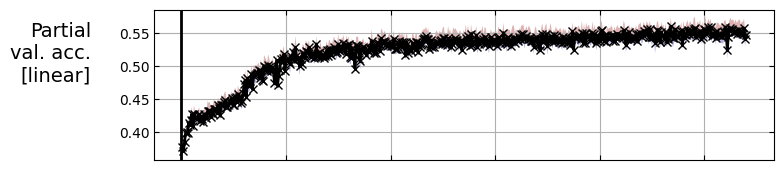

279999/539641 [==============>...............] - ETA: 10:20:53 - loss: 1.2587 - masked_accuracy: 0.5234

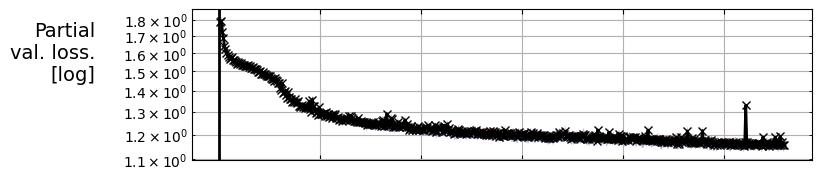

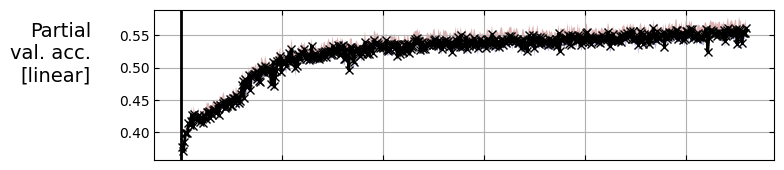

289999/539641 [===============>..............] - ETA: 9:58:38 - loss: 1.2556 - masked_accuracy: 0.5245

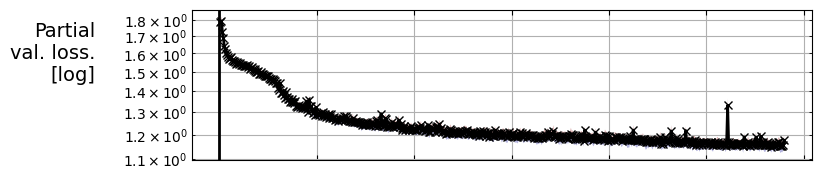

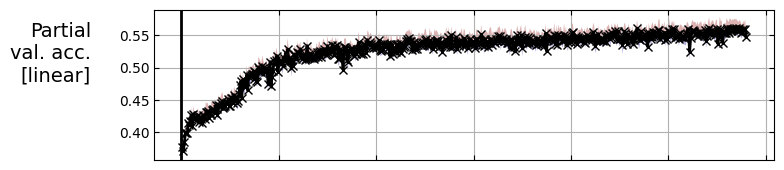

299999/539641 [===============>..............] - ETA: 9:36:29 - loss: 1.2525 - masked_accuracy: 0.5255

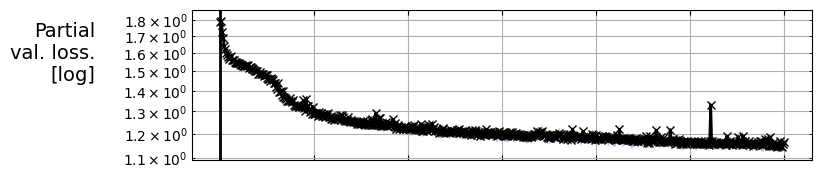

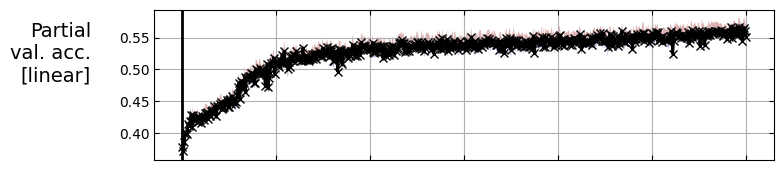

309999/539641 [================>.............] - ETA: 9:13:48 - loss: 1.2496 - masked_accuracy: 0.5265

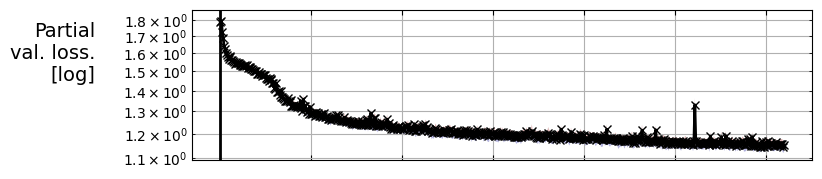

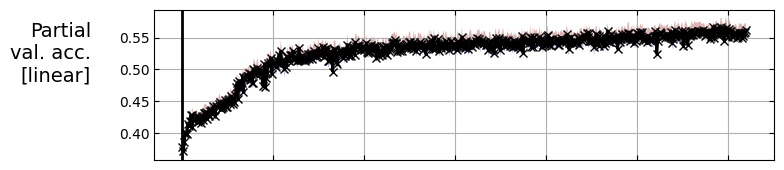

319999/539641 [================>.............] - ETA: 8:51:09 - loss: 1.2467 - masked_accuracy: 0.5275

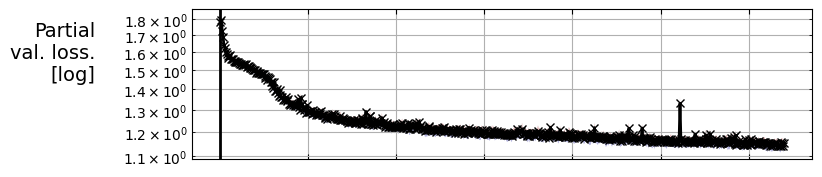

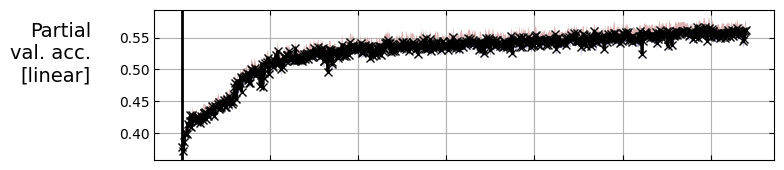

329999/539641 [=================>............] - ETA: 8:28:06 - loss: 1.2439 - masked_accuracy: 0.5284

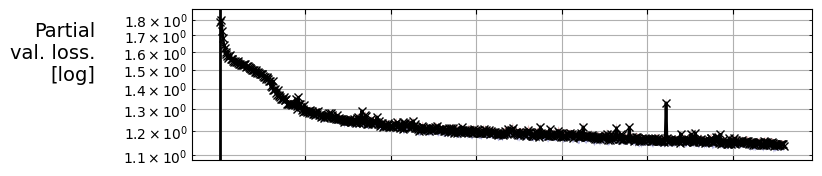

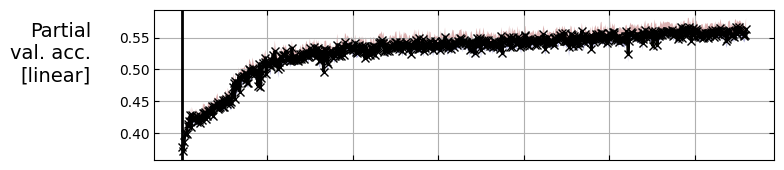

331999/539641 [=================>............] - ETA: 8:23:19 - loss: 1.2434 - masked_accuracy: 0.5286

KeyboardInterrupt: 

In [14]:
##=================##
##   Train model   ##
##=================##


##  Fit the model if configured
if global_config.get("training",{}).get("train",True) :
    max_epochs = global_config["training"]["max_epochs"]
    batch_size = global_config["training"]["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit([train_X, train_Y_in], 
              train_Y_out,
              epochs          = max_epochs,
              batch_size      = batch_size,
              validation_data = ([val_X, val_Y_in], val_Y_out),
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


In [15]:
##================##
##   Save model   ##
##================##

save_fname = f"{working_dir}/final_model.h5"
model.save(save_fname)
logger.info(f"Model save to file {save_fname}")


   INFO <module>: Model save to file unsupervised_learning_addition_model_baseline_2023_04_11_202120/final_model.h5


## 6.  Evaluate model

In [16]:

class Transformer_Seq_to_Seq :
    
    def __init__(self, model:Model, token_transform:TokenTransform) :
        """
        class Transformer_Seq_to_Seq
        
        Wrapper for sequence-to-sequence model that allows easy transform operations
        
        Input:
        
            >  model, Model
               Sequence-to-sequence keras model
            
            >  token_transform, TokenTransform
               Object giving access to (de)tokenising operations
        """
        self.model           = model
        self.token_transform = token_transform
        

    def transform_from_data_tensor(self, X, max_tokens:int=-1, device:str="CPU") :
        """
        Transform a tensor of input data into its predicted output string using argmax to select tokens
        
        Inputs:
        
            >  X, Tensor with final dimensions [S, 2]
               Tensor of (token, index) pairs for the input sequence of length S
               
            >  max_tokens, int, default=-1
               Maximum tokens in sequence
               
            >  device, str, default="CPU"
               Device to run tensorflow on
        """
        ##  Recurse over tensor of inputs
        if len(X.shape) > 1 and X.shape[0] > 1 :
            return [self.transform_from_data_tensor(Xp, max_tokens, device) for Xp in X]
        
        ##  Check arguments
        if max_tokens > 0 and max_tokens < 3 :
            raise ArgumentError(f"max_tokens must have a minimum length of 3, {max_tokens} provided")
        
        ##  If X is shape [S, F] then reshape it to [B, S, F] with B=1
        one_sequence_provided = len(X.shape) == 1
        if one_sequence_provided :
            X = X[tf.newaxis, :]
            
        #  Find tokens for start and end characters
        start_token = self.token_transform.tokeniser_dict[self.token_transform.seq_start_char]
        end_token   = self.token_transform.tokeniser_dict[self.token_transform.seq_end_char  ]

        ##  Select tf device
        with tf.device(device) :

            ##  Create initial sequence with shape [1, 1] and features [[seq_start_char]]
            Y = tf.cast([[start_token]], dtype=self.token_transform.dtype)

            ##  Keep generating tokens until we reach an end character, or the token limit
            best_token, num_tokens = start_token, 1
            while best_token != end_token and (max_tokens <= 0 or num_tokens < max_tokens) :
                
                ##  Generate logit predictions for all indices; slice logits for first sequence & final index
                token_logits = model([X, Y])[0,-1]
                
                ##  Use argmax operation to interpret the predicted token
                best_token   = np.argmax(token_logits.numpy(), axis=-1)
                
                ##  Append new token to the list
                Y = tf.concat([Y, tf.constant([[best_token]], dtype=self.token_transform.dtype)], axis=1)
                
                ##  Iterate forwards num_tokens
                num_tokens += 1

        ##  Convert tensor-of-tokens-and-indices Y into a string of detokenised characters
        out_str = "".join([self.token_transform.detokeniser_dict[t] for t in Y.numpy()[0]])
        out_str = out_str[len(self.token_transform.seq_start_char):]
        if out_str[-1] == self.token_transform.seq_end_char : out_str = out_str[:-1]
            
        ##  Return string with same format as input
        return out_str if one_sequence_provided else [out_str]
    
    
    def transform_from_string(self, X, max_tokens:int=-1, device:str="CPU") :
        """
        Transform a list of input strings into their predicted output string using argmax to select tokens
        
        Inputs:
        
            >  X, string or list of strings
               String(s) to be transformed
               
            >  max_tokens, int, default=-1
               Maximum tokens in sequence
               
            >  device, str, default="CPU"
               Device to run tensorflow on
        """
        
        ##  Cast data to list format
        one_string_provided = type(X) == str
        if one_string_provided : X = [X]
                        
        ##  Create tensor of input data
        X = self.token_transform.strings_to_tensor(X)
        
        ##  Predict outputs from tensor input
        Y = self.transform_from_data_tensor(X, max_tokens=max_tokens, device=device)
        
        ##  Return strings with same format as input
        return Y[0] if one_string_provided else Y
    
    
transformer = Transformer_Seq_to_Seq(model, token_transform)


In [17]:
##====================================##
##   Evaluate model using test data   ##
##====================================##

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Log table header
logger.info("Evaluating text --> text mathsformer on the test set:")
logger.info("-"*50)
logger.info("INPUT".rjust(12) + "TRUE".rjust(8) + "PRED".rjust(8) + "CORRECT".rjust(10) + "RESIDUAL".rjust(10))
logger.info("-"*50)

##  Get model predictions and log alongside true labels 
for x, x_str, true_y_str in zip(test_X[:num_print], 
                                token_transform.detokenise_strings(test_X    [:num_print,:].numpy()),
                                token_transform.detokenise_strings(test_Y_out[:num_print  ].numpy())) :
    pred_y_str = transformer.transform_from_data_tensor(x, max_tokens=20)
    result     = "  X" if pred_y_str == true_y_str else ""
    try    : residual = str(int(pred_y_str.replace("N","-")) - int(true_y_str.replace("N","-")))
    except : residual = "N/A"
    logger.info(x_str.rjust(12) + true_y_str.rjust(8) + pred_y_str.rjust(8) + result.rjust(8) + residual.rjust(10))


   INFO <module>: Evaluating text --> text mathsformer on the test set:
   INFO <module>: --------------------------------------------------
   INFO <module>:        INPUT    TRUE    PRED   CORRECT  RESIDUAL
   INFO <module>: --------------------------------------------------
   INFO <module>:   N1158-N277    N881    N438               443
   INFO <module>:     571-1052    N481    N536               -55
   INFO <module>:     N679-484   N1163   N1442              -279
   INFO <module>:      977-332     645    N344              -989
   INFO <module>:     592-N905    1497   N1542             -3039
   INFO <module>:     491+1308    1799    1529              -270
   INFO <module>:     914+N764     150   N1385             -1535
   INFO <module>:    N1097+177    N920    N307               613
   INFO <module>:     N114-241    N355   N1156              -801
   INFO <module>:      31-N354     385   N1349             -1734
   INFO <module>:      152-527    N375    N117               258
   INFO 

In [18]:
##======================================================================================##
##   Evaluate model using random numbers with lengths not experienced during training   ##
##======================================================================================##

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Find out the maximum number of digits to allow per input number (= 2 higher than maximum input length)
max_char = math.floor(math.log10(global_config["data"]["max_int"])) + 2

##  Log table header
logger.info(f"Evaluating text --> text mathsformer on randomly generated strings with max number length of {max_char}:")
logger.info("-"*70)
logger.info("INPUT".rjust(15) + "TRUE".rjust(15) + "PRED".rjust(15) + "RESIDUAL".rjust(15))
logger.info("-"*70)

for i in range(num_print) :
    m1, m2 = np.random.randint(low=1, high=max_char+1, size=(2,))
    n1, n2 = np.random.randint(low=10**(m1-1), high=10**m1), np.random.randint(low=10**(m2-1), high=10**m2)
    s1, s2 = np.random.choice([-1, 1], size=(2,))
    n1, n2 = s1*n1, s2*n2
    s1, s2 = str(n1).replace("-","N"), str(n2).replace("-","N")
    op = np.random.choice(["+", "-"])
    if op == "+" : answer = n1 + n2
    if op == "-" : answer = n1 - n2
    query = f"{s1}{op}{s2}"
    guess = transformer.transform_from_string(query).replace("N","-")
    try : residual = str(int(guess) - answer)
    except : residual = "N/A"
    logger.info(query.rjust(15) + str(answer).rjust(15) + guess.rjust(15) + residual.rjust(15))



   INFO <module>: Evaluating text --> text mathsformer on randomly generated strings with max number length of 5:
   INFO <module>: ----------------------------------------------------------------------
   INFO <module>:           INPUT           TRUE           PRED       RESIDUAL
   INFO <module>: ----------------------------------------------------------------------
   INFO <module>:        19+N1346          -1327          -1328             -1
   INFO <module>:          3-N210            213           -105           -318
   INFO <module>:    N61270-37802         -99072          -2452          96620
   INFO <module>:        1+N21334         -21333          -1188          20145
   INFO <module>:             7+3             10              7             -3
   INFO <module>:           31+N5             26            -15            -41
   INFO <module>:         876+722           1598           1049           -549
   INFO <module>:          55+N82            -27            -55            -

##  7. Additional visualisations

   INFO <module>: Plotting layer weights


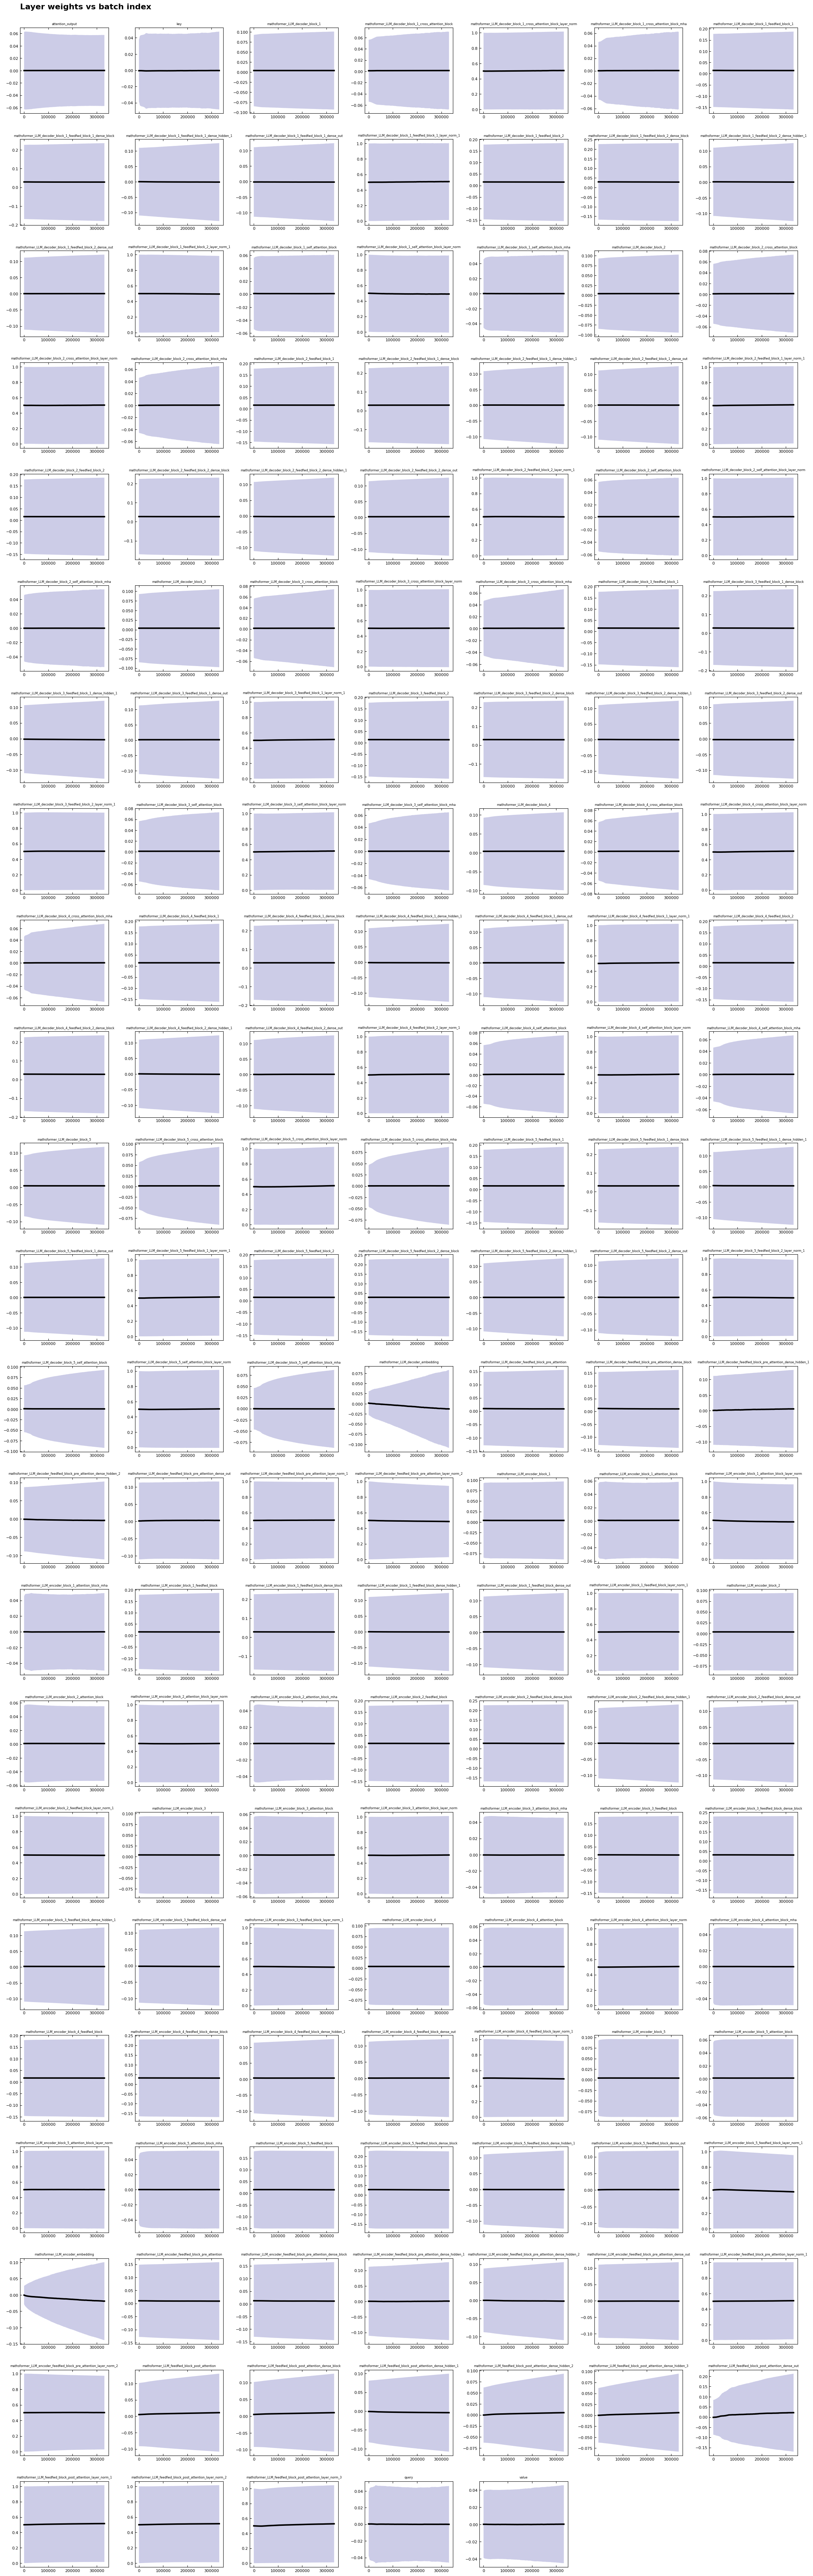

In [19]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if len(layer_weights_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    layer_weights_record.plot(num_col=7)
    